# SVM Regression

Predict a car's miles per gallon

In [76]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 6)

# Do not use normal form (scietific notation) when printing numbers, exponents can make it harder to compare values
pd.set_option('float_format', '{:f}'.format)

Populating the interactive namespace from numpy and matplotlib


In [77]:
'numpy: {}, pandas: {}, sklearn: {}'.format(np.__version__, pd.__version__, sklearn.__version__)

'numpy: 1.14.3, pandas: 0.23.0, sklearn: 0.19.1'

## Import

Data sourced from https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data

In [78]:
column_names=['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model', 'origin', 'car_name']

auto_data = pd.read_csv('../datasets/auto-mpg.data', delim_whitespace=True, header=None, na_values=['?'], names=column_names)

## Explore

In [79]:
auto_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18.000000,8,307.000000,130.000000,3504.000000,12.000000,70,1,chevrolet chevelle malibu
1,15.000000,8,350.000000,165.000000,3693.000000,11.500000,70,1,buick skylark 320
2,18.000000,8,318.000000,150.000000,3436.000000,11.000000,70,1,plymouth satellite
3,16.000000,8,304.000000,150.000000,3433.000000,12.000000,70,1,amc rebel sst
4,17.000000,8,302.000000,140.000000,3449.000000,10.500000,70,1,ford torino


In [80]:
auto_data.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [81]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      392 non-null float64
weight          398 non-null float64
acceleration    398 non-null float64
model           398 non-null int64
origin          398 non-null int64
car_name        398 non-null object
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


## Prepare

Car name is of little value when predicting mpg, so drop it

In [58]:
auto_data['car_name'].describe()

count            398
unique           305
top       ford pinto
freq               6
Name: car_name, dtype: object

In [59]:
auto_data = auto_data.drop('car_name', axis=1)
auto_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin
0,18.000000,8,307.000000,130.000000,3504.000000,12.000000,70,1
1,15.000000,8,350.000000,165.000000,3693.000000,11.500000,70,1
2,18.000000,8,318.000000,150.000000,3436.000000,11.000000,70,1
3,16.000000,8,304.000000,150.000000,3433.000000,12.000000,70,1
4,17.000000,8,302.000000,140.000000,3449.000000,10.500000,70,1


`origin` encodes where the car is from, use one-hot-encoding

In [60]:
auto_data['origin'] = auto_data['origin'].replace({
    1: 'america',
    2: 'europe',
    3: 'asia'
})
auto_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin
0,18.000000,8,307.000000,130.000000,3504.000000,12.000000,70,america
1,15.000000,8,350.000000,165.000000,3693.000000,11.500000,70,america
2,18.000000,8,318.000000,150.000000,3436.000000,11.000000,70,america
3,16.000000,8,304.000000,150.000000,3433.000000,12.000000,70,america
4,17.000000,8,302.000000,140.000000,3449.000000,10.500000,70,america


In [61]:
auto_data = pd.get_dummies(auto_data, columns=['origin'])
auto_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin_america,origin_asia,origin_europe
0,18.000000,8,307.000000,130.000000,3504.000000,12.000000,70,1,0,0
1,15.000000,8,350.000000,165.000000,3693.000000,11.500000,70,1,0,0
2,18.000000,8,318.000000,150.000000,3436.000000,11.000000,70,1,0,0
3,16.000000,8,304.000000,150.000000,3433.000000,12.000000,70,1,0,0
4,17.000000,8,302.000000,140.000000,3449.000000,10.500000,70,1,0,0


In [62]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 10 columns):
mpg               398 non-null float64
cylinders         398 non-null int64
displacement      398 non-null float64
horsepower        392 non-null float64
weight            398 non-null float64
acceleration      398 non-null float64
model             398 non-null int64
origin_america    398 non-null uint8
origin_asia       398 non-null uint8
origin_europe     398 non-null uint8
dtypes: float64(5), int64(2), uint8(3)
memory usage: 23.0 KB


Remove rows containing NaN values

In [63]:
auto_data = auto_data.dropna()

## Train

In [64]:
X = auto_data.drop('mpg', axis=1)
y = auto_data['mpg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

`C` represents the penalty for straying from the margin

In [65]:
regression_model = SVR(kernel='linear', C=0.5)
regression_model.fit(X_train, y_train)

SVR(C=0.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

## Evaluate

Get the R^2 score

In [66]:
regression_model.score(X_train, y_train)

0.8087716316091305

View the magnitude of the model coefficients

In [67]:
predictors = X_train.columns
coef = pd.Series(regression_model.coef_[0], predictors).sort_values()
coef

origin_america   -1.611964
cylinders        -0.913143
weight           -0.007247
horsepower        0.019151
displacement      0.022690
acceleration      0.219856
origin_asia       0.404608
model             0.918039
origin_europe     1.207356
dtype: float64

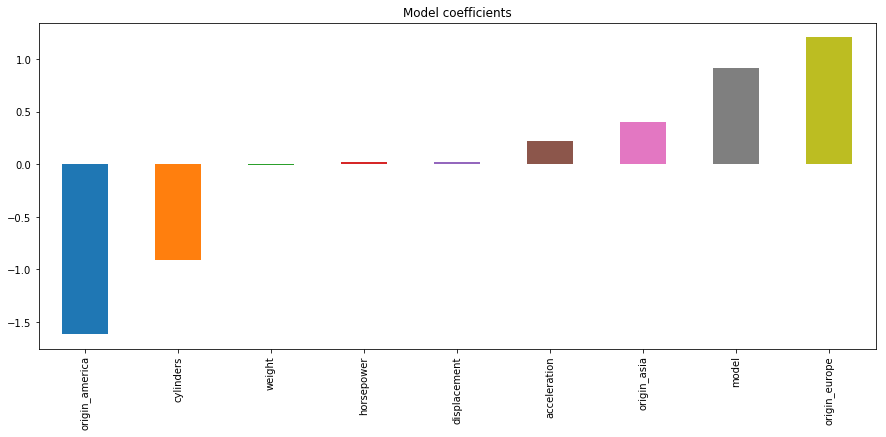

In [68]:
coef = pd.Series(regression_model.coef_[0], predictors).sort_values()
coef.plot(kind='bar', title='Model coefficients')

In [69]:
y_predict = regression_model.predict(X_test)

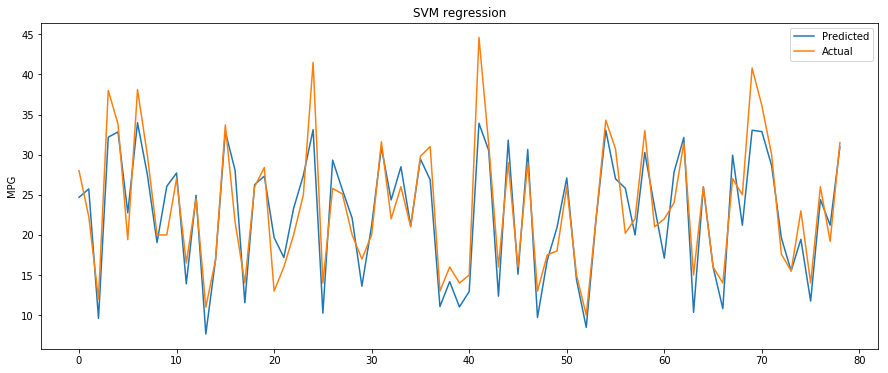

In [70]:
plt.plot(y_predict, label='Predicted')
plt.plot(y_test.values, label='Actual')
plt.ylabel('MPG')

plt.title('SVM regression')
plt.legend()
plt.show()

In [71]:
regression_model.score(X_test, y_test)

0.8262845397302738

In [72]:
mse = mean_squared_error(y_predict, y_test)
mse

10.797339127966195

On average the predicted MPG is out by around 3

In [73]:
math.sqrt(mse)

3.285930481304526